# Generalized Linear Models

In this lab, you'll build generalized linear models (GLMs) and convolutional neural network (CNN) models of retinal ganglion cell (RGC) responses to visual stimuli. You'll use PyTorch to implement the models and fit them to a dataset  kindly provided by the [Baccus Lab](https://baccuslab.stanford.edu/) (Stanford University), which they studied in the "Deep Retina" paper [(McIntosh et al, 2016)](https://arxiv.org/abs/1702.01825).

**References:**

McIntosh, Lane T., Niru Maheswaranathan, Aran Nayebi, Surya Ganguli, and Stephen A. Baccus. “Deep Learning Models of the Retinal Response to Natural Scenes.” Advances in Neural Information Processing (NeurIPS), 2017.

## Setup

In [2]:
try:
    import jaxtyping
except:
    !pip install jaxtyping

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 4.3 MB/s eta 0:00:00


In [3]:
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from copy import deepcopy
from typing import Tuple, Dict, Optional
from jaxtyping import Float
from torch import Tensor
from torch.distributions import Poisson
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import trange

# Specify that we want our tensors on the GPU and in float32
device = torch.device('cuda')
dtype = torch.float32

### Helper functions for plotting

In [4]:
#@title Helper functions for plotting (run this cell!)
sns.set_context("notebook")

# initialize a color palette for plotting
palette = sns.xkcd_palette(["windows blue",
                            "red",
                            "medium green",
                            "dusty purple",
                            "orange",
                            "amber",
                            "clay",
                            "pink",
                            "greyish"])

def plot_stimulus_weights(glm: nn.Module):
    """
    Plot the stimulus weights of a GLM.
    """
    num_neurons = glm.num_neurons
    max_delay = glm.max_delay

    fig, axs = plt.subplots(num_neurons, 3, figsize=(8, 4 * num_neurons),
                            gridspec_kw=dict(width_ratios=[1, 1.9, .1]))

    temporal_weights = glm.temporal_conv.weight[:, 0].to("cpu").detach()
    bias = glm.temporal_conv.bias.to("cpu").detach()
    spatial_weights = glm.spatial_conv.weight.to("cpu").detach()
    spatial_weights = spatial_weights.reshape(num_neurons, 50, 50)

    # normalize and flip the spatial weights
    for n in range(num_neurons):
        # Flip if spatial weight peak is negative
        if torch.allclose(spatial_weights[n].min(),
                       -abs(spatial_weights[n]).max()):
            spatial_weights[n] = -spatial_weights[n]
            temporal_weights[n] = -temporal_weights[n]

        # Normalize
        scale = torch.linalg.norm(spatial_weights[n])
        spatial_weights[n] /= scale
        temporal_weights[n] *= scale

    # Set the same limits for each neuron
    vlim = abs(spatial_weights).max()
    ylim = abs(temporal_weights).max()

    for n in range(num_neurons):
        axs[n, 0].plot(torch.arange(-max_delay+1, 1) * 10, temporal_weights[n])
        axs[n, 0].set_ylim(-ylim, ylim)
        axs[n, 0].plot(torch.arange(-max_delay+1, 1) * 10, torch.zeros(max_delay), ':k')
        if n < num_neurons - 1:
            axs[n, 0].set_xticklabels([])
        else:
            axs[n, 0].set_xlabel("$\Delta t$ [ms]")

        im = axs[n, 1].imshow(spatial_weights[n],
                              vmin=-vlim, vmax=vlim, cmap="RdBu")
        axs[n, 1].set_axis_off()
        axs[n, 1].set_title("neuron {}".format(n + 1))
        plt.colorbar(im, cax=axs[n, 2])


def plot_coupling_weights(glm: nn.Module):
    """
    Plot the coupling weights of a GLM.
    """
    # Get the weights and flip them to get time after spike
    W = glm.coupling_conv.weight.to("cpu").detach()
    W = torch.flip(W, dims=(2,))
    num_neurons = W.shape[0]
    wlim = abs(W).max()
    dt = 10 * torch.arange(W.shape[2])

    fig, axs = plt.subplots(num_neurons, num_neurons, figsize=(12, 12),
                            sharex=True, sharey=True)
    for i in range(num_neurons):
        for j in range(num_neurons):
            axs[i, j].plot(dt, 0 * dt, ':k')
            axs[i, j].plot(dt, W[i, j])
            axs[i, j].set_ylim(-wlim, wlim)
            axs[i, j].set_title("${} \\to {}$".format(j, i))

            if i == num_neurons - 1:
                axs[i, j].set_xlabel("$\Delta t$ [ms]")
    plt.tight_layout()

def plot_cnn_subunits_1(cnn: nn.Module):
    """
    Plot the first layer of subunits of a CNN.
    """
    num_subunits = cnn.num_subunits_1
    max_delay = cnn.max_delay

    fig, axs = plt.subplots(num_subunits, 3, figsize=(8, 4 * num_subunits),
                            gridspec_kw=dict(width_ratios=[1, 1.9, .1]))

    temporal_weights = cnn.temporal_conv.weight[:, 0].to("cpu").detach()
    bias = cnn.temporal_conv.bias.to("cpu").detach()
    spatial_weights = cnn.spatial_conv.weight.to("cpu").detach()
    spatial_weights = spatial_weights[:, 0, :, :]

    # normalize and flip the spatial weights
    for n in range(num_subunits):
        # Flip if spatial weight peak is negative
        if torch.allclose(spatial_weights[n].min(),
                    -abs(spatial_weights[n]).max()):
            spatial_weights[n] = -spatial_weights[n]
            temporal_weights[n] = -temporal_weights[n]

        # Normalize
        scale = torch.linalg.norm(spatial_weights[n])
        spatial_weights[n] /= scale
        temporal_weights[n] *= scale

    # Set the same limits for each neuron
    vlim = abs(spatial_weights).max()
    ylim = abs(temporal_weights).max()

    for n in range(num_subunits):
        axs[n, 0].plot(torch.arange(-max_delay+1, 1) * 10, temporal_weights[n])
        axs[n, 0].set_ylim(-ylim, ylim)
        axs[n, 0].plot(torch.arange(-max_delay+1, 1) * 10, torch.zeros(max_delay), ':k')
        if n < num_subunits - 1:
            axs[n, 0].set_xticklabels([])
        else:
            axs[n, 0].set_xlabel("$\Delta t$ [ms]")

        im = axs[n, 1].imshow(spatial_weights[n],
                              vmin=-vlim, vmax=vlim, cmap="RdBu")
        axs[n, 1].set_axis_off()
        axs[n, 1].set_title("subunit 1,{}".format(n + 1))
        plt.colorbar(im, cax=axs[n, 2])

def plot_cnn_subunits2(cnn: nn.Module):
    """
    Plot the second layer of subunits of a CNN.
    """
    cnn_filters_2 = cnn.layer2.weight.to("cpu").detach()

    fig, axs = plt.subplots(cnn.num_subunits_2,
                            cnn.num_subunits_1,
                            figsize=(4 * cnn.num_subunits_2,
                                    4 * cnn.num_subunits_1),
                            sharex=True, sharey=True)
    vlim = abs(cnn_filters_2).max()
    for i in range(cnn.num_subunits_2):
        for j in range(cnn.num_subunits_1):
            axs[i, j].imshow(cnn_filters_2[i, j],
                            vmin=-vlim, vmax=vlim, cmap="RdBu")

            axs[i, j].set_title('subunit 1,{} $\\to$ 2,{}'.format(j+1,i+1))


### Helper function to train a Pytorch model.

We've slightly modified the `train_model` function from the previous lab. This version keeps track of the model with the best validation loss over the course of the training epochs.

In [5]:
#@title Implement `train_model` function (run this cell!)
def train_model(model: nn.Module,
                train_dataset: Dataset,
                val_dataset: Dataset,
                objective: callable,
                regularizer: Optional[callable]=None,
                num_epochs: int=100,
                lr: float=0.1,
                momentum: float=0.9,
                lr_step_size: int=25,
                lr_gamma: float=0.9
                ) -> Tuple[Float[Tensor, " num_epochs"],
                           Float[Tensor, " num_epochs"]]:
    """
    Train a model on the training dataset and validate it on the validation
    dataset. The model is trained using stochastic gradient descent with a
    decaying learning rate. The model is trained for `num_epochs` epochs and
    the learning rate is decayed every `lr_step_size` epochs by a factor of
    `lr_gamma`. The model is trained using the specified `objective` function
    and an optional `regularizer`.


    Parameters
    ----------
    model : nn.Module
        The model to be trained.
    train_dataset : Dataset
        The training dataset.
    val_dataset : Dataset
        The validation dataset.
    objective : callable
        The objective function to be minimized.
    regularizer : callable, optional
        The regularizer to be added to the objective function. The default
        is None.
    num_epochs : int, optional
        The number of epochs to train the model. The default is 100.
    lr : float, optional
        The learning rate for the optimizer. The default is 0.1.
    momentum : float, optional
        The momentum for the optimizer. The default is 0.9.
    lr_step_size : int, optional
        The number of epochs after which to decay the learning rate. The
        default is 25.
    lr_gamma : float, optional
        The factor by which to decay the learning rate. The default is 0.9.

    Returns
    -------
    Tuple[Float[Tensor, " num_epochs"], Float[Tensor, " num_epochs"]]
        The training and validation losses for each epoch.
    """
    # progress bars
    pbar = trange(num_epochs)
    pbar.set_description("---")
    inner_pbar = trange(len(train_dataset))
    inner_pbar.set_description("Batch")

    # data loaders for train and validation
    train_dataloader = DataLoader(train_dataset, batch_size=1)
    val_dataloader = DataLoader(val_dataset, batch_size=1)
    dataloaders = dict(train=train_dataloader, val=val_dataloader)

    # use standard SGD with a decaying learning rate
    optimizer = optim.SGD(model.parameters(),
                          lr=lr,
                          momentum=momentum)
    scheduler = lr_scheduler.StepLR(optimizer,
                                    step_size=lr_step_size,
                                    gamma=lr_gamma)

    # Keep track of the best model
    best_model_wts = deepcopy(model.state_dict())
    best_loss = 1e8

    # Track the train and validation loss
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        for phase in ['train', 'val']:
            # set model to train/validation as appropriate
            if phase == 'train':
                model.train()
                inner_pbar.reset()
            else:
                model.eval()

            # track the running loss over batches
            running_loss = 0
            running_size = 0
            for datapoint in dataloaders[phase]:
                stim_t = datapoint['stimulus'].squeeze(0)
                spikes_t = datapoint['spikes'].squeeze(0)
                if phase == "train":
                    with torch.set_grad_enabled(True):
                        optimizer.zero_grad()
                        # compute the model output and loss
                        output_t = model(stim_t, spikes_t)
                        loss_t = objective(output_t, spikes_t)
                        # only add the regularizer in the training phase
                        if regularizer is not None:
                            loss_t += regularizer(model)

                        # take the gradient and perform an sgd step
                        loss_t.backward()
                        optimizer.step()
                    inner_pbar.update(1)
                else:
                    # just compute the loss in validation
                    output_t = model(stim_t, spikes_t)
                    loss_t = objective(output_t, spikes_t)

                assert torch.isfinite(loss_t)
                running_loss += loss_t.item()
                running_size += 1

            # compute the train/validation loss and update the best
            # model parameters if this is the lowest validation loss yet
            running_loss /= running_size
            if phase == "train":
                train_losses.append(running_loss)
            else:
                val_losses.append(running_loss)
                if running_loss < best_loss:
                    best_loss = running_loss
                    best_model_wts = deepcopy(model.state_dict())

        # Update the learning rate
        scheduler.step()

        # Update the progress bar
        pbar.set_description("Epoch {:03} Train {:.4f} Val {:.4f}"\
                             .format(epoch, train_losses[-1], val_losses[-1]))
        pbar.update(1)

    # load best model weights
    model.load_state_dict(best_model_wts)

    return torch.tensor(train_losses), torch.tensor(val_losses)

### Load the data

Load the data from the HDF5 file.
- Each file contains a `train` and `test` group.
- Each group contains:
    - `time`: length `frames` array of timestamps
    - `stimulus`: a `frames x 50 x 50` video taken at ~100Hz
    - `response`: a group with
        - `binned`: `cells x frames` array of spike counts (for the training data) or rates (for the test data) in each bin
        - `firing_rate_xms` where `x` is 5, 10, or 20 milliseconds



In [6]:
!wget -nc https://github.com/slinderman/ml4nd/raw/refs/heads/main/data/04_glms/lab4_data.h5

--2025-04-28 14:39:57--  https://github.com/slinderman/ml4nd/raw/refs/heads/main/data/04_glms/lab4_data.h5
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/slinderman/ml4nd/refs/heads/main/data/04_glms/lab4_data.h5 [following]
--2025-04-28 14:39:57--  https://media.githubusercontent.com/media/slinderman/ml4nd/refs/heads/main/data/04_glms/lab4_data.h5
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1026877736 (979M) [application/octet-stream]
Saving to: ‘lab4_data.h5’

lab4_data.h5        100%[===================>] 979.31M   192MB/s    in 4.5s    

2025-04-28 14:40:19 (216 MB/s) - 

In [7]:
# Load the white noise data
f = h5py.File("lab4_data.h5", mode='r')
times = torch.tensor(f['train']['time'][:], dtype=dtype)
stimulus = torch.tensor(f['train']['stimulus'][:], dtype=torch.uint8)
spikes = torch.tensor(f['train']['response']['binned'][:].T, dtype=dtype)
test_times = torch.tensor(f['test']['time'][:], dtype=dtype)
test_stimulus = torch.tensor(f['test']['stimulus'][:], dtype=torch.uint8)
test_rates = torch.tensor(f['test']['response']['binned'][:, :-1].T, dtype=dtype)

In [8]:
# Extract/set some constants.
NUM_FRAMES, HEIGHT, WIDTH = stimulus.shape
_, NUM_NEURONS = spikes.shape
FRAME_RATE = 100    # Hz
MAX_DELAY = 40      # frames

## Part 1: Plot the data

Always visualize your data first!

### Problem 1a: Plot a slice of the spike train

Write a function to `imshow` a slice of the data.
Add a colorbar and label your axes!


In [9]:
import numpy as np

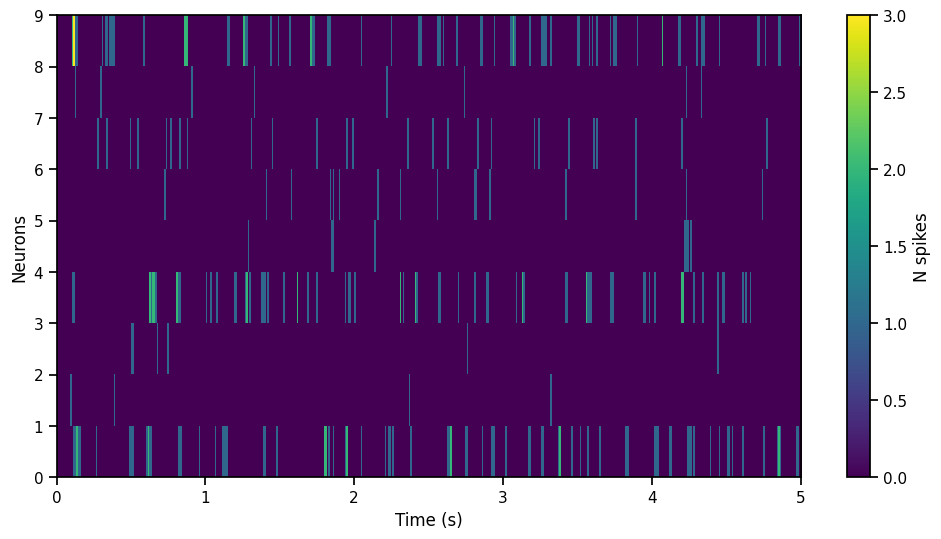

In [10]:
# Plot a few seconds of the spike train
def plot_spike_train(spikes: Float[Tensor, "num_frames num_neurons"],
                     t_start: float,
                     t_stop: float,
                     figsize: Tuple[int, int]=(12, 6)
                     ) -> None:
    """
    Visualize a window of the spike count matrix.

    spikes:  time x neuron spike count matrix
    t_start: time (in seconds) of the start of the window
    t_stop:  time (in seconds) of the end of the window
    figsize: width and height of the figure in inches
    """
    plt.figure(figsize=figsize)

    ###
    # YOUR CODE BELOW

    x_axis = np.linspace(t_start, t_stop, (t_stop - t_start) * FRAME_RATE)
    plt.imshow(spikes[int(t_start * FRAME_RATE) : int(t_stop * FRAME_RATE), :].T,
               aspect = 'auto', extent=[t_start, t_stop, 0, spikes.shape[1]],
               interpolation = 'nearest', origin = 'lower')

    plt.colorbar(label = "N spikes")

    plt.xlabel("Time (s)")
    plt.ylabel("Neurons")

    ###

plot_spike_train(spikes, 0, 5)

In [11]:
spikes.shape

torch.Size([359802, 9])

### Problem 1b: Compute the baseline firing rate for each neuron

Print the mean firing rate for each neuron (on the training data) in spikes per second.

In [12]:
###
# Compute the firing rates
# YOUR CODE BELOW

total_time = spikes.shape[1] / FRAME_RATE

for ineuron, neuron in enumerate(spikes.T):

  print(f"Mean firing rate: {round(float(neuron.sum() / total_time), 2)} per sec")

###

Mean firing rate: 286233.31 per sec
Mean firing rate: 76833.33 per sec
Mean firing rate: 79244.44 per sec
Mean firing rate: 251699.98 per sec
Mean firing rate: 56122.22 per sec
Mean firing rate: 53211.11 per sec
Mean firing rate: 73944.45 per sec
Mean firing rate: 18677.78 per sec
Mean firing rate: 151866.66 per sec


### Plot a few frames of the stimulus

Plot the 0th, 10th, 20th, and 30th frames of stimulus in grayscale.

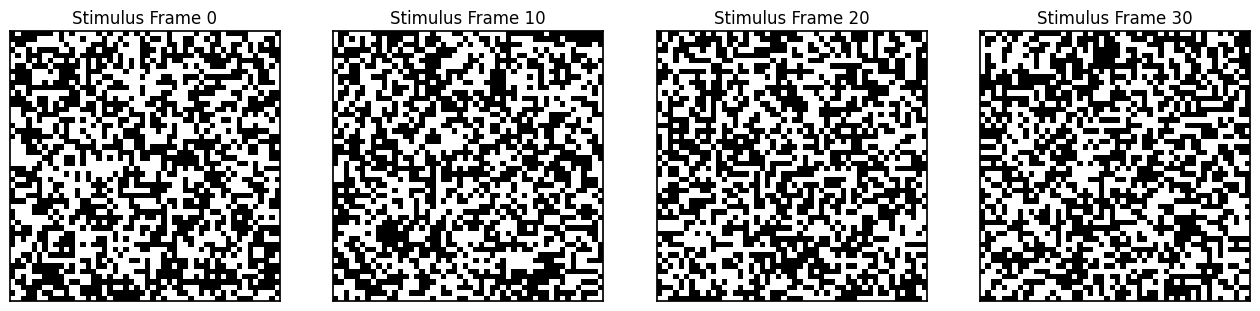

In [13]:
# Plot a few frames of stimulus
def plot_stimulus(stimulus, frame_inds, n_cols=4, panel_size=4):
    num_frames = len(frame_inds)
    n_rows = int(torch.ceil(torch.tensor(num_frames / n_cols)))
    fig, axs = plt.subplots(
        n_rows, n_cols, figsize=(n_cols * panel_size, n_rows * panel_size))
    for ax, ind in zip(axs.ravel(), frame_inds):
        ax.imshow(stimulus[ind], cmap="Greys")
        ax.set_title("Stimulus Frame {}".format(ind))
        ax.set_xticks([])
        ax.set_yticks([])
    for ax in axs.ravel()[len(frame_inds):]:
        ax.set_visible(False)

plot_stimulus(stimulus, [0, 10, 20, 30])


### Problem 1c: Compute and plot the spike triggered average

The spike triggered average for neuron $n$ is the average stimulus in the lead-up to a spike by that neuron.

Formally, let $A_n \in \mathbb{R}^{D \times P_H \times P_W}$ denote the STA for neuron $n$. It's defined as,
\begin{align}
A_{n,d,i,j} = \frac{1}{S_{n,d}} \sum_{t=d+1}^T x_{t-d,i,j} \mathbb{I}[y_{t,n} >0]
\end{align}
where $S_{n,d} = \sum_{t=d+1}^T \mathbb{I}[y_{t,n} >0]$ is the number of spikes on neuron $n$, accounting for edge effects.

In [14]:
print(spikes.max())

tensor(4.)


torch.Size([25, 50, 50])
torch.Size([359802, 50, 50])
torch.Size([359802, 9])
torch.Size([359802])
tensor([[[63.5419, 63.6124, 63.9539,  ..., 64.1220, 63.9051, 64.4038],
         [64.4635, 63.3576, 63.1625,  ..., 63.7750, 63.4877, 64.6424],
         [64.3117, 64.7887, 64.3117,  ..., 64.1436, 63.1408, 64.5339],
         ...,
         [63.7154, 63.5311, 62.8969,  ..., 64.1545, 64.6207, 63.9106],
         [63.4932, 64.3280, 64.4201,  ..., 64.3008, 64.2304, 63.8076],
         [63.4064, 64.2900, 63.2601,  ..., 63.7642, 65.1411, 64.0190]],

        [[63.6585, 63.9078, 63.9892,  ..., 64.1924, 64.0217, 64.5421],
         [64.3496, 63.3685, 63.4118,  ..., 63.8563, 63.4118, 64.7182],
         [64.2548, 64.6559, 64.2602,  ..., 64.3307, 63.2899, 64.2846],
         ...,
         [63.6666, 63.3929, 62.8671,  ..., 64.0515, 64.5827, 63.6829],
         [63.6639, 64.2033, 64.2954,  ..., 64.4933, 64.0623, 63.9133],
         [63.3793, 64.2792, 63.2248,  ..., 63.8753, 65.3362, 63.9566]],

        [[63.7281

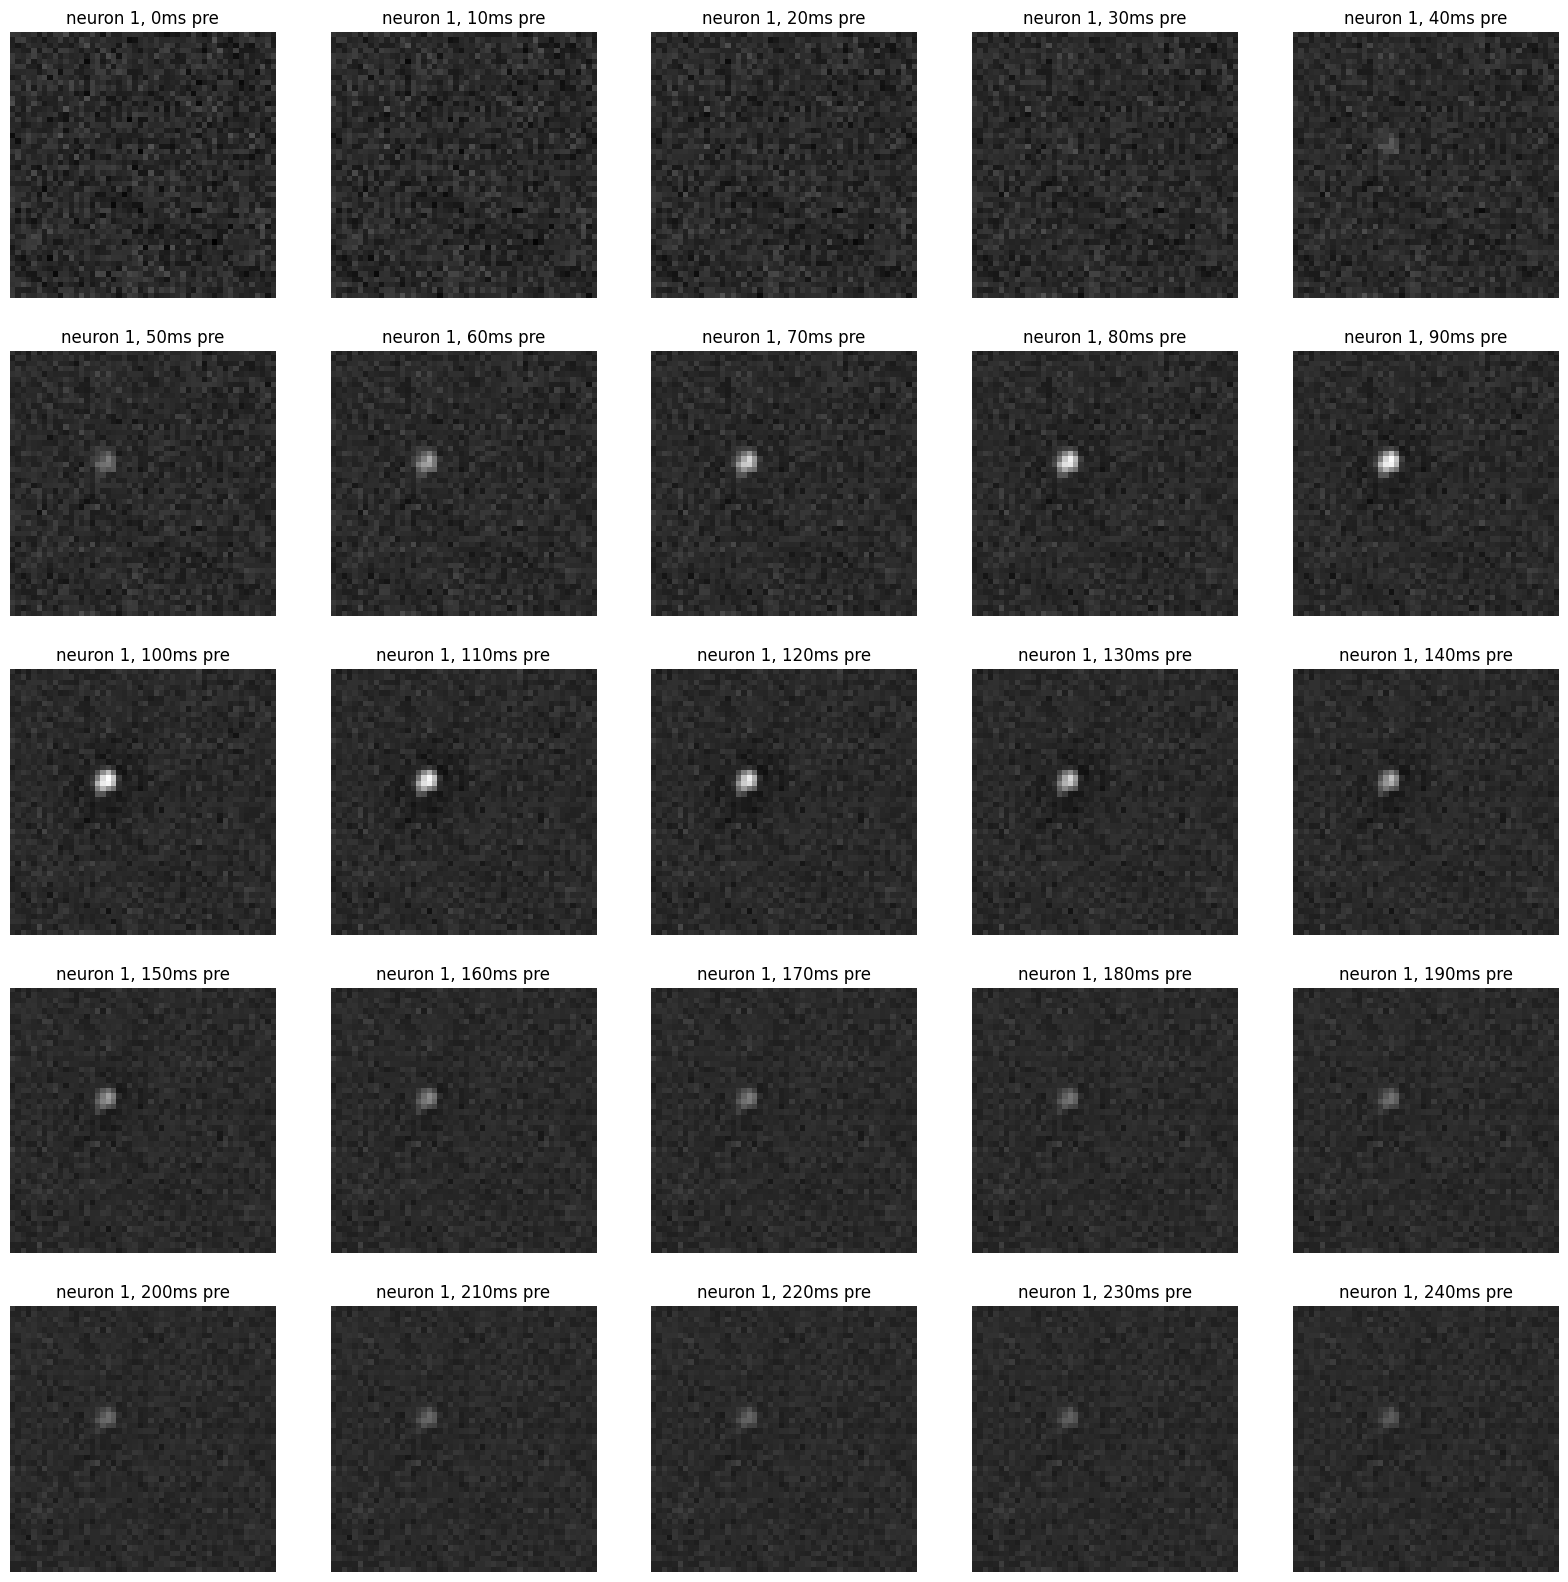

In [15]:
def compute_sta(neuron: int,
                stimulus: Float[Tensor, "num_frames height width"],
                spikes: Float[Tensor, "num_frames num_neurons"],
                max_delay: int=25
                ) -> Float[Tensor, "max_delay height width"]:
    """
    Compute the spike triggered average (STA) for a specified neuron.

    Parameters
    ----------
    neuron : int
        index of the neuron
    stimulus : Float[Tensor, "num_frames height width"]
        stimulus array
    spikes : Float[Tensor, "num_frames num_neurons"]
        spike count array
    max_delay : int
        number of preceding frames (D) in the STA

    Returns
    -------
    Float[Tensor, "max_delay height width"]
        spike triggered average (STA) for the specified neuron
    """
    stim_shape = stimulus.shape[1:]
    sta = torch.zeros((max_delay,) + stim_shape)

    ###
    # YOUR CODE BELOW


    print(sta.shape)
    print(stimulus.shape)
    print(spikes.shape)

    neuron_ts = spikes.T[neuron, :]
    print(neuron_ts.shape)

    n_spikes = 0
    for ival, val in enumerate(neuron_ts):

      if val > 0 and ival > max_delay + 1:

        n_spikes = n_spikes + 1

        for i in range(max_delay):
          sta[i, :, :] = sta[i, :, :] + torch.mean(stimulus[ival - 2 - i : ival - 1, :, :].float(), axis = 0)

    sta = sta / n_spikes

    print(sta)

    ###
    return sta

def plot_sta(neuron: int,
             sta: Float[Tensor, "max_delay height width"],
             n_cols: int=5
             ) -> None:
    """
    Plot the spike triggered average (STA) for a specified neuron.

    Parameters
    ----------
    neuron : int
        index of the neuron
    sta : Float[Tensor, "max_delay height width"]
        spike triggered average (STA) for the specified neuron
    n_cols : int
        number of columns in the plot

    """
    max_delay = sta.shape[0]
    n_rows = int(torch.ceil(torch.tensor(max_delay / n_cols)))

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(4 * n_rows, 4 * n_cols))
    vmin = sta.min()
    vmax = sta.max()
    for d, ax in enumerate(axs.ravel()):
        ax.imshow(sta[d], vmin=vmin, vmax=vmax, cmap="Greys")
        ax.set_axis_off()
        ax.set_title("neuron {}, {}ms pre".format(neuron + 1, d*10))
    for ax in axs.ravel()[max_delay:]:
        ax.set_visible(False)

n = 0
sta = compute_sta(n, stimulus, spikes)
plot_sta(n, sta)

### Finally, create PyTorch Datasets containing the stimuli and the spikes.
Before moving onto the modeling sections, we'll split the training stimulus and spikes into batches of length 1000 frames (10 seconds of data). Then we'll randomly assign 20% of the batches to a validation dataset. We've written a simple dataset to get the training and validation batches. For stability, we normalize the stimulus to be binary rather than 0 or 128, as in the raw data.

In [16]:
class RGCDataset(Dataset):
    """
    Dataset for the RGC white noise data.
    """
    stimulus: Float[Tensor, "num_frames height width"]
    spikes: Float[Tensor, "num_frames num_neurons"]

    def __init__(self,
                 stimulus: Float[Tensor, "num_frames height width"],
                 spikes: Float[Tensor, "num_frames num_neurons"]
                 ) -> None:
        self.stimulus = stimulus
        self.spikes = spikes

    def __len__(self):
        # Return the number of frames in the dataset
        return self.stimulus.shape[0]

    def __getitem__(self,
                    idx: int
                    ) -> Dict[str, Float[Tensor, "..."]]:
        # Binarize the stimulus, move it and the spikes to the GPU,
        # and package into a dictionary
        x = self.stimulus[idx].to(device).type(dtype) / 128.0
        y = self.spikes[idx].to(device)
        return dict(stimulus=x, spikes=y)

def make_datasets(batch_size: int=1000
                  ) -> Tuple[RGCDataset, RGCDataset]:
    """
    Create the training and validation datasets.

    Parameters
    ----------
    batch_size : int
        The number of frames in each batch.

    Returns
    -------
    Tuple[RGCDataset, RGCDataset]
        The training and validation datasets.
    """
    n_batches = NUM_FRAMES // batch_size
    batched_stimulus = stimulus[:n_batches * batch_size]
    batched_stimulus = batched_stimulus.reshape(n_batches, batch_size, HEIGHT, WIDTH)
    batched_spikes = spikes[:n_batches * batch_size]
    batched_spikes = batched_spikes.reshape(n_batches, batch_size, NUM_NEURONS)

    # Split into train and validation
    torch.manual_seed(0)
    n_train = int(0.8 * n_batches)
    order = torch.randperm(n_batches)
    train_stimulus = batched_stimulus[:n_train]
    val_stimulus = batched_stimulus[n_train:]
    train_spikes = batched_spikes[:n_train]
    val_spikes = batched_spikes[n_train:]

    train_dataset = RGCDataset(train_stimulus, train_spikes)
    val_dataset = RGCDataset(val_stimulus, val_spikes)
    return train_dataset, val_dataset

train_dataset, val_dataset = make_datasets()

## Part 2: Fit a linear-nonlinear Poisson (LNP) model

Let's start with a simple linear-nonlinear-Poisson (LNP) model. In statistics, we would just call this a generalized linear model (GLM), but here we'll stick to the neuroscience lingo to be consistent with McIntosh et al. (2016). LNP models (and GLMs more generally) are natural models for count data, like spike counts. Whereas standard linear models could ouput negative means, these models are constrained to output non-negative expected spike counts. Moreover, since they use a Poisson noise model, the variance of the spike counts will grow with the mean, unlike in typical linear regression models.

The basic LNP model is,

$$
\begin{aligned}
\mathbb{E}[y_{t,n} \mid \mathbf{X}, \mathbf{W}_n]
&= f \left(\sum_{d=1}^D \sum_{i=1}^{P_H} \sum_{j=1}^{P_W} x_{t-d,i,j} w_{n,d,i,j} \right)
\end{aligned}
$$

where $\mathbf{W}_n \in \mathbb{R}^{D \times P_h \times P_W}$ are the weights, and entry $w_{n,d,i,j}$ is the weight neuron $n$ gives to the simulus at pixel $i,j$ at $d$ frames preceding the current time. Assume the weights factor into a **spatial footprint** $\mathbf{u}_n \in \mathbb{R}^{P_H \times P_W}$ times a temporal profile $\mathbf{v}_n \in \mathbb{R}^D$.

$$
w_{n,d,i,j} = v_{n,d} u_{n,i,j}
$$

Then the expected value can be written as,

$$
\begin{aligned}
\mathbb{E}[y_{t,n} \mid X]
&= f \left( \sum_{d=1}^D v_{n,d} \left(\sum_{i=1}^{P_H} \sum_{j=1}^{P_W} x_{t-d,i,j} u_{n,i,j} \right) \right) \\
&= f \left( \sum_{d=1}^D v_{n,d} \tilde{x}_{n,t-d} \right) \\
&= f \left( a_{t,n} \right)
\end{aligned}
$$

where

$$
a_{t,n} = [\tilde{\mathbf{x}}_n \star \mathbf{v}_n]_t
$$

is the **activation** of neuron $n$ at time $t$. The activation is a cross-correlation (convolution in PyTorch) between $\tilde{\mathbf{x}}_{n} \in \mathbb{R}^T$, the stimulus projected onto the spatial filter for neuron $n$, and $\mathbf{v}_n$, the temporal profile for neuron $n$. The mean function $f: \mathbb{R} \to \mathbb{R}_+$ maps activation to a non-negative expected spike count.

Once we compute $\mathbb{E}[y_{t,n} \mid \mathbf{X}, \mathbf{W}_n]$ we compute the likelihood function based on a Poisson regression model:

$$
\begin{aligned}
\log p(y_{t,n}; \mathbf{X} \mathbf{W}_n) &= \mathrm{Po}(y_{t,n}; f ( a_{t,n} )) \\
&= \log f( a_{t,n})- f ( a_{t,n} ) - \log(y_{t,n}!)
\\ & = y_{t,n} a_{t,n}- \exp ( a_{t,n} ) - \log(y_{t,n}!)
\end{aligned}
$$

where $f(a) = e^a$.

Summing across samples in $t$ leads to the full likelihood for estimating the parameters for a given neuron. We can do this simultaneously across all neurons by summing over $n$ too, as gradient descent will independently update each neuron's parameters.


### Problem 2a: Implement the model

Let's start by implementing the GLM model as a class that inherits from `nn.Module`. The  `forward` method returns the mean spike count for each time bin
given the stimulus. In the loss function below (Problem 2b), we'll pass this output to the mean of a Poisson distribution.

**Notes:**
- As in Lab 2, you should first project the stimulus onto the spatial filters with a linear layer, then you can convolve with the temporal filters.
- Even though the spatial projection is a linear layer, we'll call it `spatial_conv` since its a factor of a spatiotemporal convolution. This naming will also be consistent with our models below.
- Both `spatial_conv` and `temporal_conv` include a learnable bias, by default. We only need one, so turn off the bias in the spatial layer.
- `mean_function` specifies the mapping from the linear predictor to the expected spike count. We'll use an exponential function to be consistent with the lecture, but `F.softplus` is more common in practice. (It tends to be a little more stable during training.
- We set the initial bias to a value that is roughly the log of the average spike count so that our initial means are in the right ballpark.
- We'll add a small positive constant to the firing rate in the `forward` function to ensure that we don't get `log(0)` errors during training.
- `forward` takes a keyword argument `spikes`. We won't use it in this model, but we need it here so that our training algorithm will work for this model as well as the later ones.

In [71]:
class LNP(nn.Module):
    """
    A linear-nonlinear-Poisson (LNP) model for RGC data, as described above.

    The model consists of a linear filter (spatial and temporay convolution) followed by
    a nonlinear function to produce the mean of a Poisson spike count distribution.

    Parameters
    ----------
    num_neurons : int
        The number of neurons in the model.
    height : int
        The height of the stimulus in pixels.
    width : int
        The width of the stimulus in pixels.
    max_delay : int
        The maximum delay in frames for the temporal convolution.
    mean_function : callable
        The function to compute the mean of the Poisson distribution.
    initial_bias : float
        The initial bias for the temporal convolution.
    spatial_conv : nn.Linear
        The linear layer for the spatial convolution.
    temporal_conv : nn.Conv1d
        The convolutional layer for the temporal convolution.
    """
    num_neurons: int
    height: int
    width: int
    max_delay: int
    mean_function: callable
    initial_bias: float
    spatial_conv: nn.Linear
    temporal_conv: nn.Conv1d

    def __init__(self,
                 num_neurons=NUM_NEURONS,
                 height=HEIGHT,
                 width=WIDTH,
                 max_delay=MAX_DELAY,
                 mean_function=torch.exp,
                 initial_bias=0.05):
        super(LNP, self).__init__()
        self.num_neurons = num_neurons
        self.height = height
        self.width = width
        self.max_delay = max_delay
        self.mean_function = mean_function

        ###
        # YOUR CODE BELOW
        #

        # print(initial_bias)

        kernel_size = 3
        padding = kernel_size // 2

        output_channels = 20

        self.spatial_conv = nn.Linear(self.height * self.width, output_channels, bias = False)
        self.temporal_conv = nn.Conv1d(output_channels, self.num_neurons, kernel_size = kernel_size, padding = padding)

        #
        ###

        # Initialize the bias
        torch.nn.init.constant_(self.temporal_conv.bias,
                                torch.log(torch.tensor(initial_bias)))

    def forward(self,
                stimulus: Float[Tensor, "num_frames height width"],
                spikes: Optional[Float[Tensor, "num_frames num_neurons"]]=None
                ) -> Float[Tensor, "num_frames num_neurons"]:
        """
        Compute the expected spike counts for a given stimulus.

        Parameters
        ----------
        stimulus : Float[Tensor, "num_frames height width"]
            The stimulus to be processed.
        spikes : Float[Tensor, "num_frames num_neurons"], optional
            The spike counts for the neurons. This is NOT USED in the model,
            but is included for compatibility with the training loop.

        Returns
        -------
        Float[Tensor, "num_frames num_neurons"]
            The expected spike counts for the neurons.

        """
        ###
        # YOUR CODE BELOW
        #

        x = stimulus

        # print(x.shape)
        x = x.reshape(x.shape[0], -1)
        # print(x.shape)

        x = self.spatial_conv(x)

        # print(x.shape)
        x = x.T.unsqueeze(0)
        # print(x.shape)

        x = self.temporal_conv(x)
        x = self.mean_function(x)

        # print(x.shape)
        x = x.squeeze(0).permute(1, 0)
        # print(x.shape)


        ###

        return 1e-4 + x


def check_model_outputs(model):
    """
    Check that the model outputs are the right shape and non-negative.
    """
    out = model(train_dataset[0]['stimulus'],
                train_dataset[0]['spikes'])

    print(train_dataset[0]['spikes'].shape, out.shape)

    assert out.shape == train_dataset[0]['spikes'].shape
    assert torch.all(out > 0)

# Construct an LNP model with random initial weights.
# Fix the seed so that the tests below will work
torch.manual_seed(0)
lnp = LNP().to(device)
check_model_outputs(lnp)

torch.Size([1000, 9]) torch.Size([1000, 9])


### Problem 2b: Implement the Poisson loss
Compute the average negative log likelihood of the spikes (taking the mean over neurons and frames) given the expected spike counts (`rates`) ouput by the model.

$$
\begin{aligned}
\mathcal{L}(\mathbf{W}) = -\frac{1}{NT} \sum_{n=1}^N \sum_{t=1}^T \log \mathrm{Po}(y_{t,n} \mid f(a_{t,n})
\end{aligned}
$$


In [72]:
def poisson_loss(rate: Float[Tensor, "num_frames num_neurons"],
                 spikes: Float[Tensor, "num_frames num_neurons"]):
    """Compute the log-likelihood under a Poisson spiking model.

    Parameters
    ----------
    rate: Float[Tensor, "num_frames num_neurons"]
        The expected spike counts for the neurons.
    spikes: Float[Tensor, "num_frames num_neurons"]
        The actual spike counts for the neurons.

    Returns
    -------
    Float[Tensor, "num_frames num_neurons"]
        The negative log likelihood of the Poisson distribution.
        This is the loss function for the LNP and subsequent GLM models.

    """
    ###
    # YOUR CODE BELOW

    print(rate.shape, spikes.shape)

    avg_nll = (-1 / (spikes.shape[0] * spikes.shape[1])) * torch.sum(spikes * torch.log(rate) - rate)

    print(avg_nll)

    ###

    return avg_nll

assert torch.isclose(
    poisson_loss(lnp(train_dataset[0]['stimulus']),
                 train_dataset[0]['spikes']),
    torch.tensor(0.2675), atol=1e-4)

torch.Size([1000, 9]) torch.Size([1000, 9])
tensor(0.2574, device='cuda:0', grad_fn=<MulBackward0>)


AssertionError: 

### Problem 2c: Add $\ell_2$ weight regularization

To the Poisson loss above, we'll add a regularization penalty on the squared $\ell_2$ norm of the weights,

$$
\begin{aligned}
\mathcal{R}(\mathbf{W}) &= \frac{\alpha}{2} \sum_{n=1}^N (\|\mathbf{u}_n\|_F^2 + \|\mathbf{v}_n\|_F^2)
\end{aligned}
$$

where $\mathbf{u}_n$ and $\mathbf{v}_n$ are the spatial and temporal weights for neuron $n$, respectively, and $\alpha$ is a scaling factor.

Do not regularize the biases.


In [ ]:
def lnp_regularizer(model: LNP,
                    alpha: float=1e-3
                    ) -> float:
    """
    Compute the log prior probability under a mean-zero Gaussian model.

    Parameters
    ----------
    model: LNP
        The LNP model to be regularized.
    alpha: float
        The regularization strength.

    Returns
    -------
    float
        The regularization term for the model. This is the sum of the
        squared weights of the spatial and temporal convolution filters.

    """
    ###
    # YOUR CODE BELOW
    reg = ...
    ###

    return reg

### Fit the LNP model

In [ ]:
# Construct an LNP model with random initial weights.
torch.manual_seed(0)
lnp = LNP().to(device)

# Fit the LNP model
print("Training LNP model. This should take about 2 minutes...")
train_losses, val_losses = \
    train_model(lnp,
                train_dataset,
                val_dataset,
                poisson_loss,
                lnp_regularizer)


### Plot the results

In [ ]:
# Plot the training and validation curves
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(train_losses, color=palette[0], label="train")
axs[0].plot(val_losses, color=palette[1], ls='--', label="validation")
axs[0].set_xlabel("epoch")
axs[0].set_ylabel("poisson loss")
axs[0].grid(True)
axs[0].legend(loc="upper right")

axs[1].plot(train_losses, color=palette[0], label="train")
axs[1].plot(val_losses, color=palette[1], ls='--', label="validation")
axs[1].set_xlabel("epoch")
axs[1].set_ylabel("poisson loss")
axs[1].set_ylim(top=val_losses[20])
axs[1].grid(True)

plt.tight_layout()

In [ ]:
plot_stimulus_weights(lnp)

### Problem 2d: [Short Answer] Interpret the results

How do the spatiotemporal filters relate to the STA from Problem 1c? Are they mathematically related?

---



_Your answer here_

## Part 3: Fit a GLM with inter-neuron couplings

Now add inter-neuron couplings to the basic model above. For historical reasons, the LNP with inter-neuron couplings is what some neuroscientists call a GLM, even though they're both instances of generalized linear models! Again, we're just going to stick to the notation of McIntosh et al (2016) for this lab anyway.  

The new model has activation,

$$
a_{t,n}
= [\tilde{\mathbf{x}}_n \star \mathbf{v}_n]_t +  \sum_{m=1}^N \sum_{d=1}^D y_{t-d,m} g_{m,n,d}
$$

where $\mathbf{G} \in \mathbb{R}^{N \times N \times D}$ is a tensor of **coupling** weights.

You can implement the activation using a convolution of $\mathbf{Y}$ and $\mathbf{G}$.

**Note:** as above, the `coupling_conv` will have a bias by default. Get rid of it. You don't need it since there's already a bias in the `temporal_conv`.

**IMPORTANT:** Make sure your output only depends on spike counts up to but _not including_ time $t$!!

### Problem 3a: Implement the coupled model

In [ ]:
class GLM(nn.Module):
    """
    A generalized linear model (GLM) with a spatiotemporal filter
    and coupling weights. The model consists of a linear filter (spatial and
    temporal convolution) followed by a nonlinear function to produce the mean
    of a Poisson spike count distribution. The model also includes coupling
    weights to account for the influence of other neurons on the firing rate
    of a neuron.
    Parameters
    ----------
    num_neurons : int
        The number of neurons in the model.
    height : int
        The height of the stimulus in pixels.
    width : int
        The width of the stimulus in pixels.
    max_delay : int
        The maximum delay in frames for the temporal convolution.
    mean_function : callable
        The function to compute the mean of the Poisson distribution.
    initial_bias : float
        The initial bias for the temporal convolution.
    spatial_conv : nn.Linear
        The linear layer for the spatial convolution.
    temporal_conv : nn.Conv1d
        The convolutional layer for the temporal convolution.
    coupling_conv : nn.Conv1d
        The convolutional layer for the coupling weights.
    """
    num_neurons: int
    height: int
    width: int
    max_delay: int
    mean_function: callable
    spatial_conv: nn.Linear
    temporal_conv: nn.Conv1d
    coupling_conv: nn.Conv1d

    def __init__(self,
                 num_neurons: int=NUM_NEURONS,
                 height: int=HEIGHT,
                 width: int=WIDTH,
                 max_delay: int=MAX_DELAY,
                 initial_bias: float=0.05,
                 mean_function: callable=torch.exp
                 ) -> None:
        super(GLM, self).__init__()
        self.num_neurons = num_neurons
        self.height = height
        self.width = width
        self.max_delay = max_delay
        self.mean_function = mean_function

        ###
        # YOUR CODE BELOW
        #
        self.spatial_conv = nn.Linear(...)
        self.temporal_conv = nn.Conv1d(...)
        self.coupling_conv = nn.Conv1d(...)
        ###

        # Initialize the bias
        torch.nn.init.constant_(self.temporal_conv.bias,
                                torch.log(torch.tensor(initial_bias)))

    def forward(self,
                stimulus: Float[Tensor, "num_frames height width"],
                spikes: Float[Tensor, "num_frames num_neurons"]
                ) -> Float[Tensor, "num_frames num_neurons"]:
        """
        Compute the expected spike counts for a given stimulus and spikes.

        Parameters
        ----------
        stimulus: Float[Tensor, "num_frames height width"]
            The stimulus to be processed.
        spikes: Float[Tensor, "num_frames num_neurons"]
            The spike counts for the neurons. This is used to compute the
            coupling weights.
        Returns
        -------
        Float[Tensor, "num_frames num_neurons"]
            The expected spike counts for the neurons.

        """
        x, y = stimulus, spikes

        ###
        # YOUR CODE BELOW
        rate = ...
        ###

        # Apply the nonlinearity and add small positive bias
        return 1e-4 + rate

# Construct a coupled GLM model with random initial weights.
torch.manual_seed(0)
glm = GLM().to(device)
check_model_outputs(glm)

### Problem 3b: Implement a regularizer for the coupled GLM weights

Put an $\ell_2$ penalty on the weights of the `spatial_conv`, `temporal_conv`, and `coupling_conv`. No need to regularize the bias. Scale the regularization by $\alpha$.

In [ ]:
def glm_regularizer(model: GLM,
                    alpha: float=1e-3
                    ) -> float:
    """
    Implement an \ell_2 penalty on the norm of the model weights,
    as described above.

    Parameters
    ----------
    model: GLM
        The GLM model to be regularized.
    alpha: float
        The regularization strength.

    Returns
    -------
    float
        The regularization term for the model. This is the sum of the
        squared weights of the spatial, temporal, and coupling convolution
        filters.
    """
    ###
    # YOUR CODE BELOW
    reg = ...
    ###

    return reg

### Fit the GLM model with couplings between neurons.

In [ ]:
# Construct a coupled GLM model with random initial weights.
torch.manual_seed(0)
glm = GLM().to(device)

# Fit the model
print("Training coupled GLM. This should take about 2-4 minutes...")
train_losses, val_losses = \
    train_model(glm,
                train_dataset,
                val_dataset,
                poisson_loss,
                glm_regularizer)


### Plot the results

In [ ]:
# Plot the training and validation curves
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(train_losses, color=palette[0], label="train")
axs[0].plot(val_losses, color=palette[1], ls='--', label="validation")
axs[0].set_xlabel("epoch")
axs[0].set_ylabel("poisson loss")
axs[0].grid(True)
axs[0].legend(loc="upper right")

axs[1].plot(train_losses, color=palette[0], label="train")
axs[1].plot(val_losses, color=palette[1], ls='--', label="validation")
axs[1].set_xlabel("epoch")
axs[1].set_ylabel("poisson loss")
axs[1].set_ylim(top=val_losses[20])
axs[1].grid(True)

plt.tight_layout()

In [ ]:
plot_stimulus_weights(glm)

In [ ]:
plot_coupling_weights(glm)

### Problem 3c: [Short Answer] Interpret the results

Did adding the coupling weights change the spatiotemporal stimulus filters in any perceptible way? Do you see any interesting structure in the coupling weights? What other regularization strategies could you have applied to the coupling weights?



_Your answer here_

## Part 4: Convolutional neural network model

Finally, we'll implement a convolutional neural network like the one proposed in McIntosh et al (2016). (See above.) We'll make some slight modifications though, so that the model doesn't take so long to fit.


### Problem 4a: Implement the convolutional model

Implement the following model:

1. **Apply a rank-1 spatiotemporal filter to the video:**

    a.  First convolve with 2D receptive fields of size `rf_size_1` and `num_subunits_1` output channels. You do not need to pad the edges since the neurons respond primarily to the center of the video. Your output should be `T x N1 x H1 x W1` where `T` is the number of frames, `N1` is the number of subunits, and `H1,W1` are the height and width after 2D convolution without padding.

    b.  Then convolve each subunit and pixel with a temporal filter, to get another `T x N1 x H1 x W1` output.

    c.  Apply a rectifying nonlinearity (`F.relu`).

2. **Spatial convolution and mixing**

    a.  Apply a spatial convolution of size `rf_size_2` with `num_subunits_2` output channels. This layer mixes the subunits from the first layer to obtain a representation that is, hopefully, somewhat similar to that of intermediate cells in the retina.
    
    b.  Apply another rectifying nonlinearity (`F.relu`). The output should be `T x N2 x H2 x W2` where `N2` is the number of subunits in the second layer and `H2,W2` are the size of the image after convolution without padding.

3. **Predict expected spike counts**

    a. Apply a linear read-out to the `N2 x H2 x W2` representation and pass through the mean function to obtain a `T x N` tensor of expected spike counts, where `N` is the number of neurons.


**Notes:** The modifications we made are

- We used slightly larger receptive field sizes. This actually speeds things up since, with valid padding, we end up with fewer "pixels" in subsequent layers.

- We used a smaller number of subunits (4/4 as opposed to 8/16). This is a smaller dataset (only 9 neurons) and we seemed to overfit with more layers.

- We use an exponential mean function to be consistent with the models above. Again, a softplus is more common in practice.

In [ ]:
class CNN(nn.Module):
    """
    A convolutional neural network (CNN) model for RGC data, as described above.
    The model consists of a series of convolutional layers followed by a
    fully connected layer to produce the mean of a Poisson spike count
    distribution. The model also includes a nonlinear activation function
    between layers to capture nonlinear features of the stimulus.

    Parameters
    ----------
    num_neurons : int
        The number of neurons in the model.
    height : int
        The height of the stimulus in pixels.
    width : int
        The width of the stimulus in pixels.
    max_delay : int
        The maximum delay in frames for the temporal convolution.
    rf_size_1 : int
        The size of the receptive field for the first layer.
    rf_size_2 : int
        The size of the receptive field for the second layer.
    num_subunits_1 : int
        The number of subunits in the first layer.
    num_subunits_2 : int
        The number of subunits in the second layer.
    mean_function : callable
        The function to compute the mean of the Poisson distribution.
    initial_bias : float
        The initial bias for the temporal convolution.
    spatial_conv : nn.Conv2d
        The convolutional layer for the spatial convolution.
    temporal_conv : nn.Conv1d
        The convolutional layer for the temporal convolution.
    layer2 : nn.Conv2d
        The convolutional layer for the second layer.
    layer3 : nn.Linear
        The fully connected layer for the output.
    """
    num_neurons: int
    height: int
    width: int
    max_delay: int
    rf_size_1: int
    rf_size_2: int
    num_subunits_1: int
    num_subunits_2: int
    mean_function: callable
    spatial_conv: nn.Conv2d
    temporal_conv: nn.Conv1d
    layer2: nn.Conv2d
    layer3: nn.Linear

    def __init__(self,
                 num_neurons: int=NUM_NEURONS,
                 height: int=HEIGHT,
                 width: int=WIDTH,
                 rf_size_1: int=21,
                 rf_size_2: int=15,
                 max_delay: int=MAX_DELAY,
                 num_subunits_1: int=4,
                 num_subunits_2: int=4,
                 initial_bias: float=0.05,
                 mean_function: callable=torch.exp):

        super(CNN, self).__init__()
        self.num_neurons = num_neurons
        self.height = height
        self.width = width
        self.max_delay = max_delay
        self.rf_size_1 = rf_size_1
        self.rf_size_2 = rf_size_2
        self.num_subunits_1 = num_subunits_1
        self.num_subunits_2 = num_subunits_2
        self.mean_function = mean_function

        ###
        # YOUR CODE BELOW
        #
        self.spatial_conv = nn.Conv2d(...)
        self.temporal_conv = nn.Conv1d(...)
        self.layer2 = nn.Conv2d(...)
        self.layer3 = nn.Linear(...)
        #
        ###

        # Initialize the bias
        torch.nn.init.constant_(self.layer3.bias,
                                torch.log(torch.tensor(initial_bias)))

    def forward(self,
                stimulus: Float[Tensor, "num_frames height width"],
                spikes: Optional[Float[Tensor, "num_frames num_neurons"]]=None
                ) -> Float[Tensor, "num_frames num_neurons"]:
        """
        Compute the expected spike counts for a given stimulus and spikes.

        Parameters
        ----------
        stimulus: Float[Tensor, "num_frames height width"]
            The stimulus to be processed.
        spikes: Float[Tensor, "num_frames num_neurons"]
            The spike counts for the neurons. This is NOT USED in this model,
            but is included for compatibility with the training loop.

        Returns
        -------
        Float[Tensor, "num_frames num_neurons"]
            The expected spike counts for the neurons.

        """
        x = stimulus
        ###
        # YOUR CODE BELOW
        rate = ...
        ###

        return 1e-4 + rate


torch.manual_seed(0)
cnn = CNN().to(device)
check_model_outputs(cnn)


### Problem 4b: Regularize the weights

Put an $\ell_2$ penalty on the weights of `spatial_conv`, `temporal_conv`, `layer2`, and `layer3`. Scale the regularize by $\alpha$, as in the preceding sections. No need to regularize the biases. We found that a smaller value of $\alpha$ was helpful, so here we default to `1e-5`.

In [ ]:
# Regularize the weights of the CNN
def cnn_regularizer(model: CNN,
                    alpha: float=1e-5
                    ) -> float:
    """
    Implement an \ell_2 penalty on the norm of the model weights,
    as described above.

    Parameters
    ----------
    model: CNN
        The CNN model to be regularized
    alpha: float
        The regularization strength.

    Returns
    -------
    float
        The regularization term for the objective. This is the sum of the
        squared weights of the spatial, temporal, and coupling convolution
        filters.
    """
    ###
    # YOUR CODE BELOW
    reg = ...
    #
    ###

    return reg

### Fit the CNN model

In [ ]:
torch.manual_seed(0)
cnn = CNN().to(device)

print("Fitting the CNN model. This should take about 10-20 minutes.")
train_losses, val_losses = \
    train_model(cnn,
                train_dataset,
                val_dataset,
                poisson_loss,
                cnn_regularizer)


### Plot the results

In [ ]:
# Plot the training and validation curves
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(train_losses, color=palette[0], label="train")
axs[0].plot(val_losses, color=palette[1], ls='--', label="validation")
axs[0].set_xlabel("epoch")
axs[0].set_ylabel("poisson loss")
axs[0].grid(True)
axs[0].legend(loc="upper right")

axs[1].plot(train_losses, color=palette[0], label="train")
axs[1].plot(val_losses, color=palette[1], ls='--', label="validation")
axs[1].set_xlabel("epoch")
axs[1].set_ylabel("poisson loss")
axs[1].set_ylim(top=val_losses[10])
axs[1].grid(True)

plt.tight_layout()

### Plot the subunit weights for the CNN

First we'll plot the spatiotemporal filters of the first layer of subunits.

In [ ]:
plot_cnn_subunits_1(cnn)

### Plot the spatial weights for the second layer of subunits.

In [ ]:
plot_cnn_subunits2(cnn)

### Problem 4c: Predict test firing rates

Finally, take the fitted models from Parts 2-4 and evaluate them on test data.

The test data consists of _expected_ spike counts rather than spike counts. That's because they showed the same visual stimulus many times and computed the average response.  If our models are working well, they should output a similar firing rate in response to that same visual stimulus.

**Note:** technically the coupled GLM from Part 3 expects preceding spikes as input, but here we'll give it the rates as input instead. (We don't have test spikes to feed in.)

In [ ]:
# Move the test stimulus and measured rates to the GPU
test_stimulus_cuda = test_stimulus.to(device).type(dtype) / 128.0
test_rates_cuda = test_rates.to(device)

###
# YOUR CODE BELOW
#
lnp_test_rates = ...
glm_test_rates = ...
cnn_test_rates = ...

# Plot a slice of the true and predicted firing rates
...
#
###

plt.tight_layout()

### Problem 4d: Model comparison

Make a bar plot of the mean squared error between the true and predicted rates for each model. As a baseline, compute the mean squared error of a constant-rate model with rate equal to the expected spike count under the training data.


In [ ]:
###
# YOUR CODE BELOW
#
mse_const = ...
mse_lnp = ...
mse_glm = ...
mse_cnn = ...
#
###

# Make a bar plot
plt.bar(0, mse_const, color='gray', ec='k')
plt.bar(1, mse_lnp, color=palette[0], ec='k')
plt.bar(2, mse_glm, color=palette[1], ec='k')
plt.bar(3, mse_cnn, color=palette[2], ec='k')
plt.xticks([0, 1, 2, 3], ["Const.", "LNP", "GLM", "CNN"])
plt.ylabel("Test MSE")

## Part 5: Discussion

You've now developed and fit three encoding models for these retinal ganglion cell responses, and hopefully you've developed some intuition for how these models work! Let's end by discussing some of the decisions that go into building and checking these models.


### Problem 5a
All three models were fit with a Poisson loss, which has unit dispersion. What is overdispersion of count data? Is this an issue here?


_Your answer here_

### Problem 5b
The CNN was loosely motivated as an approximation to the layers of photoreceptors, bipolar cells, etc. that precede retinal ganglion cells. Of course, the actual circuitry is more complicated. What could you imagine adding to this model to make it more realistic?


_Your answer here_

### Problem 5c
In our hands, the CNN outperformed the LNP and GLM. Though it's tempting to just say the CNN is a more flexible model, notice that the CNN does not have coupling filters and it compresses the input substantially before the final read-out layer. Given the results above, what follow-up experiments would you do to further understand the root of these performance differences?


_Your answer here_

### Problem 5d
We didn't ask you to do a thorough hyperparameter search. If you were to do one, what are the key parameters you would vary to try to improve model performance?


_Your answer here_

### Problem 5e

We fit all of these models to RGC responses to a binary white noise stimulus. Would you expect your results to change if the cells had been shown a movie with natural scenes instead?


_Your answer here_

## Author contributions

Write a short paragraph describing how each team member contributed to this assignment.

_Your answer here_

## Submission Instructions


Download your notebook in .ipynb format and use the following command to convert it to PDF
```
jupyter nbconvert --to pdf lab4_teamname.ipynb
```
If you're using Anaconda for package management, you can install `nbconvert` with
```
conda install -c anaconda nbconvert
```
Upload your .pdf file to Gradescope.

**Only one submission per team!**